In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/ECOmmerceDAnalysis/data_rfm_pcapped_3dt1.pkl'
data_rfm_pcapped_3dt1 = pd.read_pickle(file_path, )

# Inspect the data
# Percentage based capped data 0.1% & 99%
print(data_rfm_pcapped_3dt1.head())
print(data_rfm_pcapped_3dt1.info())
print(data_rfm_pcapped_3dt1.shape)
print(data_rfm_pcapped_3dt1.describe().T)
print(data_rfm_pcapped_3dt1.nunique())
print(data_rfm_pcapped_3dt1.isnull().sum())
print(data_rfm_pcapped_3dt1.duplicated().sum())
print(data_rfm_pcapped_3dt1[~data_rfm_pcapped_3dt1.isnull().any(axis=1) & ~data_rfm_pcapped_3dt1.duplicated()])
print((data_rfm_pcapped_3dt1['Quantity'] < 0).sum(), (data_rfm_pcapped_3dt1['UnitPrice'] < 0).sum())
print(data_rfm_pcapped_3dt1.columns)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   

   DayOfWeek  ...  Month  Year  recency  frequency  monetary  recency_score  \
0          2  ...     12  2010 

In [ ]:
data_rfm_pcapped_3dt2 = data_rfm_pcapped_3dt1.copy()
# Calculate the average purchase value per customer
data_rfm_pcapped_3dt2['avg_purchase_value'] = data_rfm_pcapped_3dt2['monetary'] / data_rfm_pcapped_3dt2['frequency']

# Assume average customer lifespan of 365 days (You can adjust this based on your business assumption)
data_rfm_pcapped_3dt2['customer_lifespan'] = 365  # This can be dynamic or adjusted later

# Calculate the CLV for each customer using the formula
data_rfm_pcapped_3dt2['CLV'] = data_rfm_pcapped_3dt2['avg_purchase_value'] * data_rfm_pcapped_3dt2['frequency'] * data_rfm_pcapped_3dt2['customer_lifespan']

# Show the CLV for the first few customers
print(data_rfm_pcapped_3dt2[['CustomerID', 'CLV']].head())


   CustomerID         CLV
0       17850  1996524.45
1       17850  1996524.45
2       17850  1996524.45
3       17850  1996524.45
4       17850  1996524.45


In [ ]:
# Group by CustomerID and calculate the CLV once per customer
customer_clv = data_rfm_pcapped_3dt2.groupby('CustomerID')['CLV'].max().reset_index()

# Show the first few rows of CLV per customer
print(customer_clv.head())


   CustomerID         CLV
0       12347  1547381.00
1       12348   524592.60
2       12349   532005.75
3       12350   107456.00
4       12352   505795.10


In [ ]:
# Create quantile-based segmentation (High, Medium, Low CLV)
customer_clv['CLV_Segment'] = pd.qcut(customer_clv['CLV'], q=3, labels=["Low", "Medium", "High"])

# Show the first few rows of the segmented customer CLV
print(customer_clv.head())


   CustomerID         CLV CLV_Segment
0       12347  1547381.00        High
1       12348   524592.60        High
2       12349   532005.75        High
3       12350   107456.00         Low
4       12352   505795.10        High


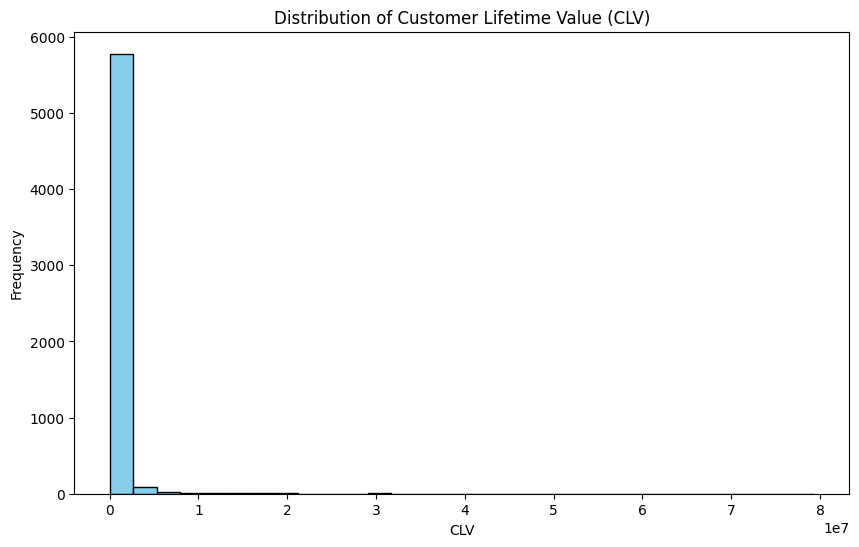

In [ ]:
import matplotlib.pyplot as plt

# Plot a histogram of CLV
plt.figure(figsize=(10, 6))
plt.hist(customer_clv['CLV'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Lifetime Value (CLV)')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.show()


In [ ]:
print(data_rfm_pcapped_3dt2.columns)
print(customer_clv.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek',
       'HourOfDay', 'Month', 'Year', 'recency', 'frequency', 'monetary',
       'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score',
       'Segment', 'avg_purchase_value', 'customer_lifespan', 'CLV'],
      dtype='object')
Index(['CustomerID', 'CLV', 'CLV_Segment'], dtype='object')


In [ ]:
# Rename the columns in customer_clv before merging to avoid any conflicts
customer_clv.rename(columns={'CLV': 'Customer_CLV', 'CLV_Segment': 'Customer_CLV_Segment'}, inplace=True)

# Merge the data again
data_rfm_pcapped_3dt3 = pd.merge(data_rfm_pcapped_3dt2, customer_clv[['CustomerID', 'Customer_CLV', 'Customer_CLV_Segment']],
                                  on='CustomerID', how='left')

# Check the columns after the merge
print(data_rfm_pcapped_3dt3.columns)

# Show the first few rows
print(data_rfm_pcapped_3dt3[['CustomerID', 'Customer_CLV', 'Customer_CLV_Segment']].head())


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek',
       'HourOfDay', 'Month', 'Year', 'recency', 'frequency', 'monetary',
       'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score',
       'Segment', 'avg_purchase_value', 'customer_lifespan', 'CLV',
       'Customer_CLV', 'Customer_CLV_Segment'],
      dtype='object')
   CustomerID  Customer_CLV Customer_CLV_Segment
0       17850    1996524.45                 High
1       17850    1996524.45                 High
2       17850    1996524.45                 High
3       17850    1996524.45                 High
4       17850    1996524.45                 High


In [ ]:
print(data_rfm_pcapped_3dt3.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek',
       'HourOfDay', 'Month', 'Year', 'recency', 'frequency', 'monetary',
       'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score',
       'Segment', 'avg_purchase_value', 'customer_lifespan', 'CLV',
       'Customer_CLV', 'Customer_CLV_Segment'],
      dtype='object')


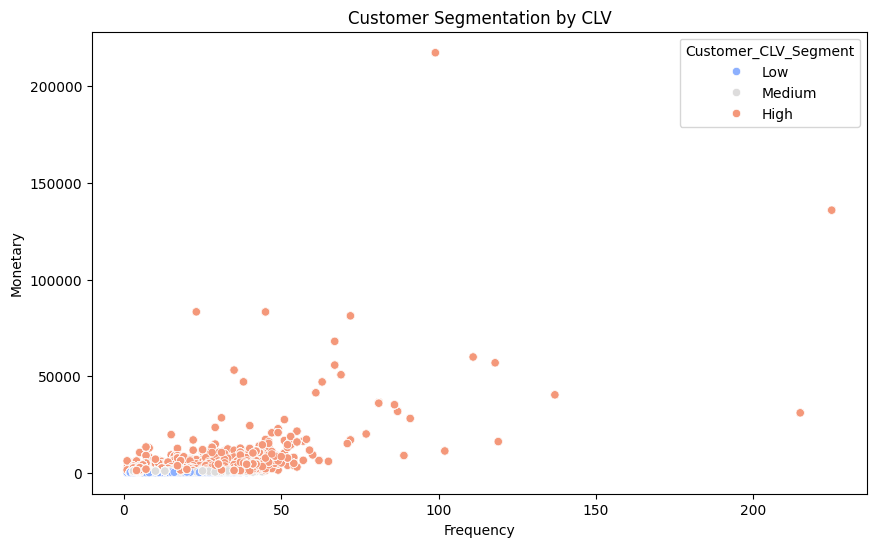

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize CLV Segments by Frequency and Monetary values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary', hue='Customer_CLV_Segment', data=data_rfm_pcapped_3dt3, palette='coolwarm')
plt.title('Customer Segmentation by CLV')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()



In [ ]:
# Group by Country and aggregate CLV, frequency, and monetary
geo_segment = data_rfm_pcapped_3dt3.groupby('Country').agg({
    'CLV': 'sum',  # Sum CLV for each country
    'frequency': 'mean',  # Average frequency per country
    'monetary': 'mean'  # Average monetary per country
}).reset_index()

# Show the geographic segmentation
print(geo_segment.head())


     Country           CLV  frequency      monetary
0  Australia  2.227032e+10  18.167797  51707.278000
1    Austria  2.361341e+08   7.192708   1684.747057
2    Bahrain  2.599983e+06   2.388889    395.735556
3    Belgium  1.840863e+09   8.169509   2606.438827
4     Brazil  1.455153e+07  11.000000   1245.850000


<ipython-input-48-b666c4ef3362>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CLV', y='Country', data=geo_segment, palette='viridis')


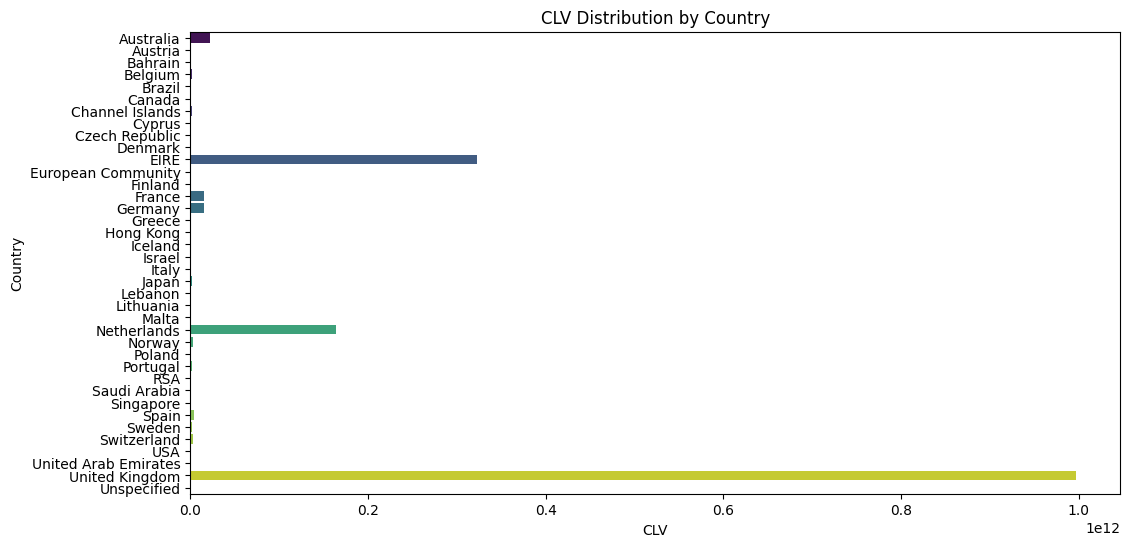

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot to visualize CLV by Country
plt.figure(figsize=(12, 6))
sns.barplot(x='CLV', y='Country', data=geo_segment, palette='viridis')
plt.title('CLV Distribution by Country')
plt.xlabel('CLV')
plt.ylabel('Country')
plt.show()


In [ ]:
# Group by Product (StockCode) and calculate total monetary value and frequency
product_segment = data_rfm_pcapped_3dt3.groupby('StockCode').agg({
    'monetary': 'sum',  # Total money spent on each product
    'frequency': 'sum'  # Number of times each product was purchased
}).reset_index()

# Sort by monetary to find high-value products
product_segment = product_segment.sort_values(by='monetary', ascending=False)

# Show the top products by monetary
print(product_segment.head())


     StockCode     monetary  frequency
1310     22423  20823272.78      73942
3385    85099B  19518818.37      76485
3405    85123A  17389514.58      81283
175      20725  14722809.86      56764
439      21212  13656786.08      47611


In [ ]:
# Scatter plot to visualize Product Frequency vs. Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary', data=product_segment, hue='StockCode', palette='coolwarm')
plt.title('Product Preferences: Frequency vs. Monetary')
plt.xlabel('Frequency of Purchases')
plt.ylabel('Monetary Value')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Group by Month to understand monthly buying patterns
monthly_segment = data_rfm_pcapped_3dt3.groupby('Month').agg({
    'frequency': 'sum',  # Total purchases per month
    'monetary': 'sum'  # Total money spent per month
}).reset_index()

# Show monthly segment data
print(monthly_segment.head())


   Month  frequency      monetary
0      1    1109669  2.403252e+08
1      2     914185  2.183336e+08
2      3    1241989  2.675289e+08
3      4    1012136  1.948257e+08
4      5    1337434  3.087191e+08


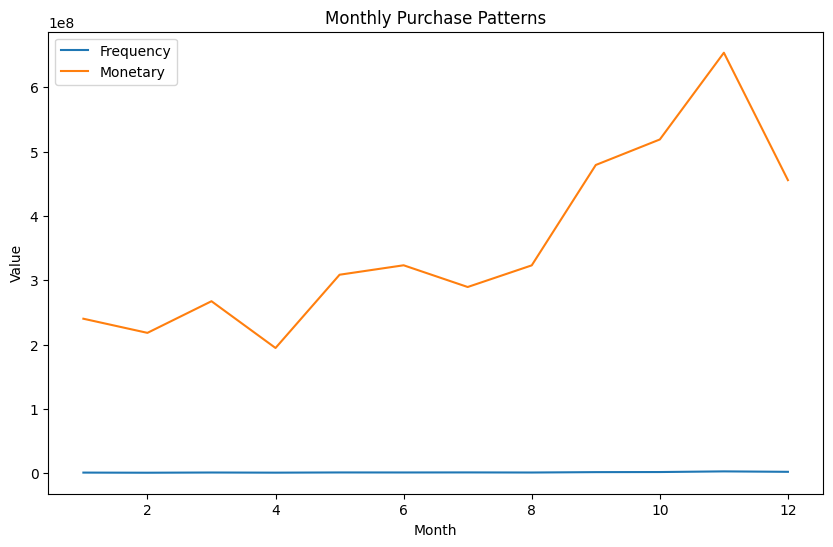

In [ ]:
# Line plot to visualize Monthly Frequency vs Monetary
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='frequency', data=monthly_segment, label='Frequency')
sns.lineplot(x='Month', y='monetary', data=monthly_segment, label='Monetary')
plt.title('Monthly Purchase Patterns')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# Merge geographic, product, and timing insights with CLV data
refined_clv_data = data_rfm_pcapped_3dt3.merge(geo_segment, on='Country', how='left')
refined_clv_data = refined_clv_data.merge(product_segment, on='StockCode', how='left')

# Check the column names
print(refined_clv_data.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek',
       'HourOfDay', 'Month', 'Year', 'recency', 'frequency_x', 'monetary_x',
       'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score',
       'Segment', 'avg_purchase_value', 'customer_lifespan', 'CLV_x',
       'Customer_CLV', 'Customer_CLV_Segment', 'CLV_y', 'frequency_y',
       'monetary_y', 'monetary', 'frequency'],
      dtype='object')


In [ ]:
# Rename columns if necessary
refined_clv_data.rename(columns={'CLV_x': 'CLV'}, inplace=True)


In [ ]:
# Create new CLV segments based on combined features
refined_clv_data['Combined_Segment'] = pd.cut(refined_clv_data['CLV'],
                                              bins=[0, 500000, 1000000, 5000000],
                                              labels=['Low', 'Medium', 'High'])

# Show refined segmentation
print(refined_clv_data[['CustomerID', 'CLV', 'Country', 'StockCode', 'Month', 'Combined_Segment']].head())


   CustomerID         CLV         Country StockCode  Month Combined_Segment
0       17850  1996524.45  United Kingdom    85123A     12             High
1       17850  1996524.45  United Kingdom     71053     12             High
2       17850  1996524.45  United Kingdom    84406B     12             High
3       17850  1996524.45  United Kingdom    84029G     12             High
4       17850  1996524.45  United Kingdom    84029E     12             High


In [ ]:
# Save the refined CLV data to a CSV file in your specified path
refined_clv_data.to_csv('/content/drive/MyDrive/ECommerce Analysis/refined_clv_data.csv', index=False)


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Initialize LabelEncoder for categorical columns
label_encoder = LabelEncoder()

# Encode categorical features 'Country' and 'StockCode'
refined_clv_data['Country'] = label_encoder.fit_transform(refined_clv_data['Country'])
refined_clv_data['StockCode'] = label_encoder.fit_transform(refined_clv_data['StockCode'])

# Initialize StandardScaler for numerical columns
scaler = StandardScaler()

# List of numerical columns to scale
numerical_columns = ['frequency', 'monetary', 'avg_purchase_value', 'customer_lifespan']

# Standardize the numerical columns
refined_clv_data[numerical_columns] = scaler.fit_transform(refined_clv_data[numerical_columns])

In [ ]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target (y)
features = ['frequency', 'monetary', 'avg_purchase_value', 'customer_lifespan', 'Country', 'StockCode']
target = 'CLV'

# Prepare the data for training and testing
data_for_training = refined_clv_data[features + [target]]

# Split the data into features (X) and target (y)
X = data_for_training.drop(columns=[target])
y = data_for_training[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (418156, 6)
Testing data shape: (104539, 6)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 2655.3216236905837
Mean Squared Error (MSE): 42362892716.972305
Root Mean Squared Error (RMSE): 205822.478648403
R-squared (R2): 0.9993579940052805


In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict using XGBoost model
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Manually calculate RMSE using numpy
rmse = np.sqrt(mse)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 3031979.9170785546
Mean Squared Error (MSE): 38713514630102.39
Root Mean Squared Error (RMSE): 6222018.533410391
R-squared (R2): 0.4133000162373073


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming X_train and X_test are your feature sets and y_train, y_test are the target labels

# Define categorical features (For example, let's assume 'Country' and 'StockCode' are categorical)
# If using column names, you can use the column names directly; if using indices, you can pass indices.
cat_features = ['Country', 'StockCode']  # Example: adjust this based on your dataset

# Initialize the CatBoost Regressor model
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, cat_features=cat_features, verbose=200)

# Fit the model
catboost_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = catboost_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Manually calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


0:	learn: 7818384.2366187	total: 320ms	remaining: 5m 19s
200:	learn: 1091872.6019016	total: 39.6s	remaining: 2m 37s
400:	learn: 917011.3258415	total: 1m 20s	remaining: 2m
600:	learn: 869963.2808585	total: 1m 59s	remaining: 1m 19s
800:	learn: 842970.6465263	total: 2m 39s	remaining: 39.6s
999:	learn: 825569.5595580	total: 3m 20s	remaining: 0us
Mean Absolute Error (MAE): 322973.09034945886
Mean Squared Error (MSE): 757838282505.38
Root Mean Squared Error (RMSE): 870539.0758061237
R-squared (R2): 0.9885150260241439


In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the CatBoost Regressor model
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, cat_features=cat_features, verbose=200)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
mse_list = []
rmse_list = []
r2_list = []

# Perform cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the model
    catboost_model.fit(X_train_cv, y_train_cv)

    # Predict on validation set
    y_pred_cv = catboost_model.predict(X_val_cv)

    # Calculate metrics
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    mse = mean_squared_error(y_val_cv, y_pred_cv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_cv, y_pred_cv)

    # Append to lists
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calculate mean metrics
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_r2 = np.mean(r2_list)

print("Cross-validation Results")
print(f"Mean Absolute Error (MAE): {mean_mae}")
print(f"Mean Squared Error (MSE): {mean_mse}")
print(f"Root Mean Squared Error (RMSE): {mean_rmse}")
print(f"R-squared (R2): {mean_r2}")


0:	learn: 7830284.0292873	total: 958ms	remaining: 15m 57s
200:	learn: 1062451.1751630	total: 35.8s	remaining: 2m 22s
400:	learn: 856607.2058766	total: 1m 6s	remaining: 1m 39s
600:	learn: 810511.7598742	total: 1m 38s	remaining: 1m 5s
800:	learn: 787658.7314230	total: 2m 9s	remaining: 32.2s
999:	learn: 771798.2321330	total: 2m 40s	remaining: 0us
0:	learn: 7871608.9577616	total: 171ms	remaining: 2m 51s
200:	learn: 1117216.7553448	total: 30.6s	remaining: 2m 1s
400:	learn: 919840.4702562	total: 1m 2s	remaining: 1m 32s
600:	learn: 865655.8306080	total: 1m 35s	remaining: 1m 3s
800:	learn: 843890.8134057	total: 2m 4s	remaining: 31s
999:	learn: 829496.4207533	total: 2m 34s	remaining: 0us
0:	learn: 7836979.9776233	total: 161ms	remaining: 2m 40s
200:	learn: 1145182.8426183	total: 31.1s	remaining: 2m 3s
400:	learn: 929769.9872370	total: 1m 4s	remaining: 1m 35s
600:	learn: 869415.7296476	total: 1m 35s	remaining: 1m 3s
800:	learn: 841867.9245456	total: 2m 6s	remaining: 31.4s
999:	learn: 824148.77810

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'early_stopping_rounds': [50, 100, 150]  # Early stopping to prevent overfitting
}

# Initialize the CatBoost Regressor
catboost_model = CatBoostRegressor(cat_features=cat_features, verbose=0)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(catboost_model, param_dist, n_iter=10, cv=5, verbose=3, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate the best model on the test data
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'subsample': 0.8, 'learning_rate': 0.2, 'l2_leaf_reg': 5, 'iterations': 1000, 'early_stopping_rounds': 150, 'depth': 10, 'colsample_bylevel': 0.8}
Best Cross-Validation Score: 0.9912910769743103
Mean Absolute Error (MAE): 291032.4654863974
Mean Squared Error (MSE): 625269931383.7985
Root Mean Squared Error (RMSE): 790740.1162099963
R-squared (R2): 0.9905240879807661


In [ ]:
# Evaluate the model performance on the test data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Predict the CLV on the test data
y_pred_test = best_model.predict(X_test)

# Display the first few predictions
print("Predictions on Test Data:")
print(y_pred_test[:10])  # Display the first 10 predictions

# Calculate MAE, MSE, and R2
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

# Manually calculate RMSE (Root Mean Squared Error)
rmse_test = mse_test ** 0.5

# Calculate R-squared (R2)
r2_test = r2_score(y_test, y_pred_test)

# Print the results
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")


Predictions on Test Data:
[ 4783577.62194186 21989033.14110335  3323521.87731677   598402.22285262
   311967.51540719   540310.07573458  2559262.91996953    70818.58847043
   370421.58994732   804182.54450202]
Mean Absolute Error (MAE): 291032.4654863974
Mean Squared Error (MSE): 625269931383.7985
Root Mean Squared Error (RMSE): 790740.1162099963
R-squared (R2): 0.9905240879807661


In [ ]:
import joblib

# Define the model path
model_path = '/content/drive/MyDrive/ECommerce Analysis/EcommerceCLVCatBoost.pkl'

# Save the model using joblib
joblib.dump(catboost_model, model_path)

print(f'Model saved successfully at {model_path}')


Model saved successfully at /content/drive/MyDrive/ECommerce Analysis/EcommerceCLVCatBoost.pkl
